### Check influence of different parameters in performance. 

Check influence of:
- specifying different chunk sizes and chunking along different dimensions
- use already standardized data --> does it save memory?
- use ``` .persist()``` to load data in a distributed way and speed up reading



In [1]:
standardization_contants = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp
import random

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg_nearest/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2
nb_timesteps = 2
len_sqce = 2
# define time resolution
delta_t = 6

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,4"
gpu = [0,1]
num_workers = 10
pin_memory = True
batch_size = 95

nb_epochs = 10
learning_rate = 8e-3


In [5]:
from modules.data import WeatherBenchDatasetIterative
class WeatherBenchDatasetXarrayHealpixTemp(Dataset):
    
    """ Dataset used for graph models (1D), where data is loaded from stored numpy arrays.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    out_features : int
        Number of output features
    delta_t : int
        Temporal spacing between samples in temporal sequence (in hours)
    len_sqce : int
        Length of the input and output (predicted) sequences
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
        
    def __init__(self, ds, out_features, delta_t, len_sqce, years, nodes, nb_timesteps, 
                 max_lead_time=None, load=False, mean=None, std=None, standardize=True):
        
        
        self.delta_t = delta_t
        self.len_sqce = len_sqce
        self.years = years
        
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        
        self.in_features = self.data.shape[-1]
        
        if standardize:
            self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
            self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        eps = 0.001 #add to std to avoid division by 0
        
        # Count total number of samples
        total_samples = self.data.shape[0]        
        
        if max_lead_time is None:
            self.n_samples = total_samples - (len_sqce+1) * delta_t
        else:
            self.n_samples = total_samples - (len_sqce+1) * delta_t - max_lead_time
        
        # Normalize
        if standardize:
            self.data = (self.data - self.mean.to_array(dim='level')) / (self.std.to_array(dim='level') + eps)
        
        self.data.persist()
        self.idxs = np.array(range(self.n_samples))
        
        if load:
            print('Loading data to RAM...')
            self.data.load()
        
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, len_sqce, n_features]
            
        """
        idx_data = idx#self.idxs[idx]
        #1,0,2
        
        #batch[0] --> (batch_size, num_nodes, n_features*len_sq)
        idx_full = np.concatenate([idx_data+delta_t,  idx_data + delta_t * len_sqce, idx_data + delta_t * (len_sqce+1)])
        dat = self.data.isel(time=idx_full).values
        
        
        X = (
            torch.tensor(dat[:len(idx),:,:] , \
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),
        )
        
        y = (torch.tensor(dat[len(idx):len(idx)*2,:,:],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),\
             torch.tensor(dat[len(idx)*2:,:,:out_features],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1)
        
        )
        return X, y 

Define model

In [6]:
#description = "no_const"
description = "all_const_hd5"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

In [7]:
# Model #old: in_channels=in_features*len_sqce
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=7, out_channels=2, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

In [8]:
def train_model_2steps_custom(model, device, training_ds, constants, batch_size, epochs, lr, validation_ds):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    n_samples = training_ds.n_samples
    n_samples_val = validation_ds.n_samples
    num_nodes = training_ds.nodes
    num_constants = constants.shape[1]
    out_features = training_ds.out_features
    
    constants_expanded = constants.expand(batch_size, num_nodes, num_constants)
    constants1 = constants_expanded.to(device)
    idxs_val = validation_ds.idxs
    
    for epoch in range(epochs):
        
        print('\rEpoch : {}'.format(epoch), end="")
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        
        random.shuffle(training_ds.idxs)
        idxs = training_ds.idxs
        
        batch_idx = 0
        times_read = []
        for i in range(0, n_samples - batch_size, batch_size):
            i_next = min(i + batch_size, n_samples)
            
            if len(idxs[i:i_next]) < batch_size:
                constants_expanded = contants.expand(len(idxs[i:i_next]), num_nodes, num_constants)
                constants1 = constants_expanded.to(device)
        
            
            t1 = time.time()
            batch, labels = training_ds[idxs[i:i_next]]
            
            t2 = time.time()
            
            # Transfer to GPU
            
            
            batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
            label1 = labels[0].to(device)
            label2 = labels[1].to(device)
            
            
            t3 = time.time()
            batch_size = batch1.shape[0]
            
            # Model
            
            t4 = time.time()
            output1 = model(batch1)  
            t5 = time.time()
            batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
            t6 = time.time()
            output2 = model(batch2)
            t7 = time.time()
            loss = criterion(output1, label1[:,:,:out_features]) + criterion(output2, label2)
            t8 = time.time()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
            
            print('\nTime to read batch: {}s'.format(t2-t1))
            print('Time to transfer data to GPU: {}s'.format(t3-t2))
            print('Time to process input 1: {}s'.format(t5-t4))
            print('Time to process input 2: {}s'.format(t7-t6))
            print('Time to compute loss: {}s'.format(t8-t7))
            print('\n')
            print('\rBatch idx: {}; Loss: {:.3f}'.format(batch_idx, train_loss/(batch_size*(batch_idx+1))), end="")
            times_read.append(t2-t1)
            
            if len(times_read) == 10: 
                print('Reading time: {} +- {}'.format(np.mean(times_read), np.std(times_read)))
                return times_read
            batch_idx += 1
        
        train_loss = train_loss / n_samples
        train_losses.append(train_loss)
        
        model.eval()
        
        constants1 = constants_expanded.to(device)
        with torch.set_grad_enabled(False):
            index = 0
            
            for i in range(0, n_samples_val - batch_size, batch_size):
                i_next = min(i + batch_size, n_samples_val)

                if len(idxs_val[i:i_next]) < batch_size:
                    constants_expanded = contants.expand(len(idxs_val[i:i_next]), num_nodes, num_constants)
                    constants1 = constants_expanded.to(device)


                #t1 = time.time()
                batch, labels = validation_ds[idxs_val[i:i_next]]
                # Transfer to GPU
                batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1[:,:,:out_features]).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / n_samples_val
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
    return train_losses, val_losses

## Explore effect of different parameters on the training time

In [9]:
class results_time():
    def __init__(self, time, chunk_size, memory, standardization):
        self.times = time
        self.chunk_size = chunk_size
        self.loaded_in_memory = memory
        self.standardized = standardization
        self.mean_time = np.mean(time)
        self.std_time = np.std(time)
        self.max_time = np.max(time)
        self.min_time = np.min(time)
        
    def print(self):
        print('Parameters: \n\t* Chunk size: {}\n\t* Loaded in memory: {}\n\t* Previously standardized: {}'.\
             format(self.chunk_size, self.loaded_in_memory, self.standardized))
        print('Loading time: {:.3f}s $\pm$ {:.3f}'.format(self.mean_time, self.std_time))
        

In [10]:
def generate_comparison(chunk_size, load_ram, data_standardized, chunk=True):
    if chunk:
        z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', \
                             chunks={'time':chunk_size}, parallel=False).rename({'z':'z500'})
        t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords', \
                                 chunks={'time':chunk_size}, parallel=False).rename({'t':'t850'})
        rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords', \
                                chunks={'time':chunk_size}, parallel=False)
    else:
        z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', \
                             parallel=False).rename({'z':'z500'})
        t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords', \
                                 parallel=False).rename({'t':'t850'})
        rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords', \
                                parallel=False)

    z500 = z500.isel(time=slice(7, None))
    t850 = t850.isel(time=slice(7, None))

    constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg_standardized.nc')
    orog = constants['orog']
    lsm = constants['lsm']
    lats = constants['lat2d']
    slt = constants['slt']
    cos_lon = constants['cos_lon']
    sin_lon = constants['sin_lon']

    num_constants = len([orog, lats, lsm, slt])
    constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                                dtype=torch.float)
    
    
    in_features = 7 #len(feature_idx)
    train_mean_ = xr.open_mfdataset(f'{input_dir}mean_train_features_dynamic.nc')
    train_std_ = xr.open_mfdataset(f'{input_dir}std_train_features_dynamic.nc')
    
    if data_standardized:
        ds = xr.merge([z500, t850, rad], compat='override')
        #ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

        ds_train = ds.sel(time=slice(*train_years))
        ds_valid = ds.sel(time=slice(*val_years))
        ds_test = ds.sel(time=slice(*test_years))
    
    else:
        ds = xr.open_mfdataset(f'{input_dir}ds_standardized.nc')

        ds_train = ds.sel(time=slice(*train_years))
        ds_valid = ds.sel(time=slice(*val_years))
        ds_test = ds.sel(time=slice(*test_years))
    
    # Train and validation data
    training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                       len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                       years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                       mean=train_mean_, std=train_std_, load=load_ram, standardize=data_standardized)
    validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                         len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                         years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                         mean=train_mean_, std=train_std_, load=load_ram, standardize=data_standardized)

    
    torch.cuda.empty_cache()
    
    times1 = train_model_2steps_custom(spherical_unet, device, training_ds, constants_tensor.transpose(1,0), batch_size, epochs=7, \
                                           lr=learning_rate, validation_ds=validation_ds)
    
    
    t1 = results_time(times1, chunk_size, load_ram, data_standardized)
    del z500, t850, ds, ds_train, ds_valid, ds_test, training_ds, validation_ds
    return t1

### Option 1. 

* chunk size = 521
* data loaded to memory = False
* data previously standardized = False

In [11]:
chunk_size = 521#483*2 #483
load_ram = False
data_standardized = True

In [ ]:
times1 = generate_comparison(chunk_size, load_ram, data_standardized)


### Option 2. 

* chunk size = 521
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [ ]:
chunk_size = 521#483*2 #483
load_ram = True
data_standardized = True

In [14]:
times2 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.020550012588500977s
Time to transfer data to GPU: 0.004224300384521484s
Time to process input 1: 0.14285993576049805s
Time to process input 2: 0.10473966598510742s
Time to compute loss: 0.05374288558959961s


Batch idx: 0; Loss: 1.799
Time to read batch: 0.027279376983642578s
Time to transfer data to GPU: 0.004503965377807617s
Time to process input 1: 0.03518533706665039s
Time to process input 2: 0.03868722915649414s
Time to compute loss: 0.15185093879699707s


Batch idx: 1; Loss: 2.141
Time to read batch: 0.025417327880859375s
Time to transfer data to GPU: 0.0046231746673583984s
Time to process input 1: 0.035918474197387695s
Time to process input 2: 0.03673601150512695s
Time to compute loss: 0.15445303916931152s


Batch idx: 2; Loss: 2.258
Time to read batch: 0.030431747436523438s
Time to transfer data to GPU: 0.0046885013580322266s
Time to process input 1: 0.036507606506347656s
Time to process input 2: 0.04

### Option 3. 

* chunk size = 1042
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

In [15]:
chunk_size = 1042#483*2 #483
load_ram = False
data_standardized = True

In [16]:
times3 = generate_comparison(chunk_size, load_ram, data_standardized)

Epoch : 0
Time to read batch: 5.12432336807251s
Time to transfer data to GPU: 0.005776643753051758s
Time to process input 1: 0.14310002326965332s
Time to process input 2: 0.0989222526550293s
Time to compute loss: 0.06920576095581055s


Batch idx: 0; Loss: 1.268
Time to read batch: 5.266407489776611s
Time to transfer data to GPU: 0.005630970001220703s
Time to process input 1: 0.04152846336364746s
Time to process input 2: 0.03775930404663086s
Time to compute loss: 0.1568589210510254s


Batch idx: 1; Loss: 2.051
Time to read batch: 5.873713731765747s
Time to transfer data to GPU: 0.006192922592163086s
Time to process input 1: 0.04513978958129883s
Time to process input 2: 0.03481173515319824s
Time to compute loss: 0.1525130271911621s


Batch idx: 2; Loss: 1.843
Time to read batch: 5.4166131019592285s
Time to transfer data to GPU: 0.010369062423706055s
Time to process input 1: 0.04466605186462402s
Time to process input 2: 0.039122819900512695s
Time to compute loss: 0.14989948272705078s


Ba

### Option 4. 

* chunk size = 1042
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [17]:
chunk_size = 521*2#483*2 #483
load_ram = True
data_standardized = True

In [18]:
times4 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.022547483444213867s
Time to transfer data to GPU: 0.004329204559326172s
Time to process input 1: 0.14053559303283691s
Time to process input 2: 0.08721804618835449s
Time to compute loss: 0.07735085487365723s


Batch idx: 0; Loss: 0.967
Time to read batch: 0.02686905860900879s
Time to transfer data to GPU: 0.006092548370361328s
Time to process input 1: 0.03591108322143555s
Time to process input 2: 0.03945589065551758s
Time to compute loss: 0.15108656883239746s


Batch idx: 1; Loss: 1.510
Time to read batch: 0.024672269821166992s
Time to transfer data to GPU: 0.009840250015258789s
Time to process input 1: 0.03571605682373047s
Time to process input 2: 0.03818202018737793s
Time to compute loss: 0.15278291702270508s


Batch idx: 2; Loss: 1.410
Time to read batch: 0.023598909378051758s
Time to transfer data to GPU: 0.0045871734619140625s
Time to process input 1: 0.0352938175201416s
Time to process input 2: 0.0379087

### Option 5. 

* chunk size = 483*2
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

In [19]:
chunk_size = 483*2#483*2 #483
load_ram = False
data_standardized = True

In [20]:
times5 = generate_comparison(chunk_size, load_ram, data_standardized)

Epoch : 0
Time to read batch: 3.9351730346679688s
Time to transfer data to GPU: 0.005017995834350586s
Time to process input 1: 0.15259003639221191s
Time to process input 2: 0.10401487350463867s
Time to compute loss: 0.05161261558532715s


Batch idx: 0; Loss: 0.810
Time to read batch: 3.3515727519989014s
Time to transfer data to GPU: 0.004899740219116211s
Time to process input 1: 0.037139177322387695s
Time to process input 2: 0.0388944149017334s
Time to compute loss: 0.1514267921447754s


Batch idx: 1; Loss: 1.353
Time to read batch: 4.210132837295532s
Time to transfer data to GPU: 0.00608515739440918s
Time to process input 1: 0.0434725284576416s
Time to process input 2: 0.039510250091552734s
Time to compute loss: 0.14712238311767578s


Batch idx: 2; Loss: 1.232
Time to read batch: 3.478127956390381s
Time to transfer data to GPU: 0.01313161849975586s
Time to process input 1: 0.04325580596923828s
Time to process input 2: 0.040517568588256836s
Time to compute loss: 0.14905309677124023s




### Option 6. 

* chunk size = 521
* data loaded to memory = False
* data previously standardized = True --> data_standardized = False

In [21]:
chunk_size = 521#483*2 #483
load_ram = False
data_standardized = False

In [22]:
times6 = generate_comparison(chunk_size, load_ram, data_standardized)

Epoch : 0
Time to read batch: 16.954752683639526s
Time to transfer data to GPU: 0.00801396369934082s
Time to process input 1: 0.12178969383239746s
Time to process input 2: 0.09241604804992676s
Time to compute loss: 0.06830859184265137s


Batch idx: 0; Loss: 4266.646
Time to read batch: 16.76918315887451s
Time to transfer data to GPU: 0.006953239440917969s
Time to process input 1: 0.03712296485900879s
Time to process input 2: 0.03403067588806152s
Time to compute loss: 0.15543675422668457s


Batch idx: 1; Loss: 4232.546
Time to read batch: 17.227988243103027s
Time to transfer data to GPU: 0.014900684356689453s
Time to process input 1: 0.047194480895996094s
Time to process input 2: 0.0379023551940918s
Time to compute loss: 0.16247773170471191s


Batch idx: 2; Loss: 4198.085
Time to read batch: 16.543894052505493s
Time to transfer data to GPU: 0.005876302719116211s
Time to process input 1: 0.03770279884338379s
Time to process input 2: 0.03877401351928711s
Time to compute loss: 0.1545164585

### Option 7. 

* chunk size = 521
* data loaded to memory = True
* data previously standardized = True --> data_standardized = False

In [23]:
chunk_size = 521#483*2 #483
load_ram = True
data_standardized = False

In [24]:
times7 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.034003257751464844s
Time to transfer data to GPU: 0.008423805236816406s
Time to process input 1: 0.1463792324066162s
Time to process input 2: 0.10379242897033691s
Time to compute loss: 0.05806303024291992s


Batch idx: 0; Loss: 3675.604
Time to read batch: 0.044157981872558594s
Time to transfer data to GPU: 0.021374225616455078s
Time to process input 1: 0.03419947624206543s
Time to process input 2: 0.03518962860107422s
Time to compute loss: 0.1547865867614746s


Batch idx: 1; Loss: 3676.636
Time to read batch: 0.023709774017333984s
Time to transfer data to GPU: 0.004773378372192383s
Time to process input 1: 0.03750944137573242s
Time to process input 2: 0.03886556625366211s
Time to compute loss: 0.14931178092956543s


Batch idx: 2; Loss: 3641.400
Time to read batch: 0.01960468292236328s
Time to transfer data to GPU: 0.004591941833496094s
Time to process input 1: 0.038865089416503906s
Time to process input 2: 0

### Option 8. 

* chunk size = No chunking
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

In [25]:
chunk_size = 0#483*2 #483
load_ram = False
data_standardized = True

In [26]:
times8 = generate_comparison(chunk_size, load_ram, data_standardized, chunk=False)

Epoch : 0
Time to read batch: 36.79243731498718s
Time to transfer data to GPU: 0.019695520401000977s
Time to process input 1: 0.4083981513977051s
Time to process input 2: 0.1153557300567627s
Time to compute loss: 0.048253774642944336s


Batch idx: 0; Loss: 116.617
Time to read batch: 30.328162670135498s
Time to transfer data to GPU: 0.011240720748901367s
Time to process input 1: 0.05701613426208496s
Time to process input 2: 0.036928653717041016s
Time to compute loss: 0.16907596588134766s


Batch idx: 1; Loss: 104.404
Time to read batch: 32.966477155685425s
Time to transfer data to GPU: 0.021794795989990234s
Time to process input 1: 0.04722738265991211s
Time to process input 2: 0.04008674621582031s
Time to compute loss: 0.14850783348083496s


Batch idx: 2; Loss: 94.966
Time to read batch: 37.846285820007324s
Time to transfer data to GPU: 0.023884057998657227s
Time to process input 1: 0.05755758285522461s
Time to process input 2: 0.0381169319152832s
Time to compute loss: 0.16483831405639

### Option 9. 

* chunk size = No chunking
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [27]:
chunk_size = 0#483*2 #483
load_ram = True
data_standardized = True

In [28]:
times9 = generate_comparison(chunk_size, load_ram, data_standardized, chunk=False)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.02195119857788086s
Time to transfer data to GPU: 0.004250288009643555s
Time to process input 1: 0.1352982521057129s
Time to process input 2: 0.11090445518493652s
Time to compute loss: 0.04759478569030762s


Batch idx: 0; Loss: 13.448
Time to read batch: 0.01746821403503418s
Time to transfer data to GPU: 0.006413698196411133s
Time to process input 1: 0.032997846603393555s
Time to process input 2: 0.04062390327453613s
Time to compute loss: 0.149794340133667s


Batch idx: 1; Loss: 12.745
Time to read batch: 0.021443843841552734s
Time to transfer data to GPU: 0.0047647953033447266s
Time to process input 1: 0.04076719284057617s
Time to process input 2: 0.0410771369934082s
Time to compute loss: 0.14551544189453125s


Batch idx: 2; Loss: 11.312
Time to read batch: 0.020105838775634766s
Time to transfer data to GPU: 0.004515409469604492s
Time to process input 1: 0.03725075721740723s
Time to process input 2: 0.0432510

## Compare results 

In [34]:
t = []
for times in [times1, times2, times3, times4, times5, times6, times7, times8, times9]:
    times.print()

Parameters: 
	* Chunk size: 521
	* Loaded in memory: False
	* Previously standardized: True
Loading time: 2.685s $\pm$ 0.279
Parameters: 
	* Chunk size: 521
	* Loaded in memory: True
	* Previously standardized: True
Loading time: 0.025s $\pm$ 0.003
Parameters: 
	* Chunk size: 1042
	* Loaded in memory: False
	* Previously standardized: True
Loading time: 5.236s $\pm$ 0.281
Parameters: 
	* Chunk size: 1042
	* Loaded in memory: True
	* Previously standardized: True
Loading time: 0.025s $\pm$ 0.002
Parameters: 
	* Chunk size: 966
	* Loaded in memory: False
	* Previously standardized: True
Loading time: 3.717s $\pm$ 0.360
Parameters: 
	* Chunk size: 521
	* Loaded in memory: False
	* Previously standardized: False
Loading time: 16.907s $\pm$ 0.214
Parameters: 
	* Chunk size: 521
	* Loaded in memory: True
	* Previously standardized: False
Loading time: 0.023s $\pm$ 0.009
Parameters: 
	* Chunk size: 0
	* Loaded in memory: False
	* Previously standardized: True
Loading time: 34.972s $\pm$ 2.895

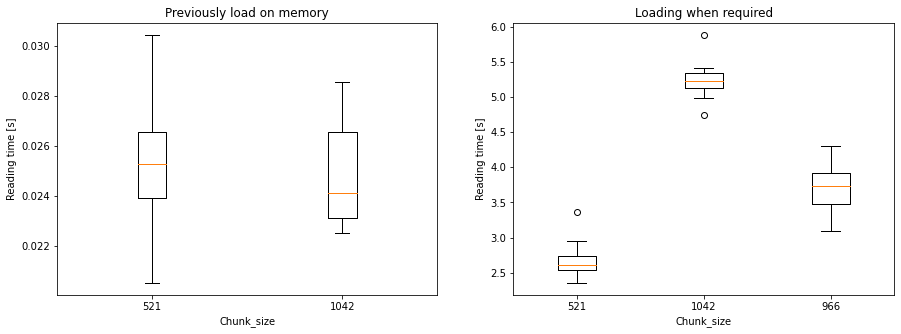

In [35]:
times_plot = [times1, times2, times3, times4, times5]

t_loaded = [t for t in times_plot if t.loaded_in_memory]
t_not_loaded = [t for t in times_plot if not t.loaded_in_memory]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Previously load on memory')
ax[1].set_title('Loading when required')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.chunk_size for t in t_list])
    ax[i].set_xlabel('Chunk_size')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

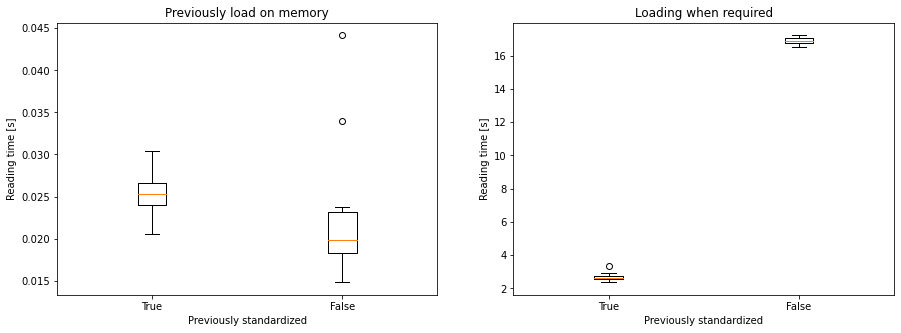

In [36]:
times_plot = [times1, times2, times6, times7]

t_loaded = [t for t in times_plot if t.loaded_in_memory]
t_not_loaded = [t for t in times_plot if not t.loaded_in_memory]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Previously load on memory')
ax[1].set_title('Loading when required')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.standardized for t in t_list])
    ax[i].set_xlabel('Previously standardized')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

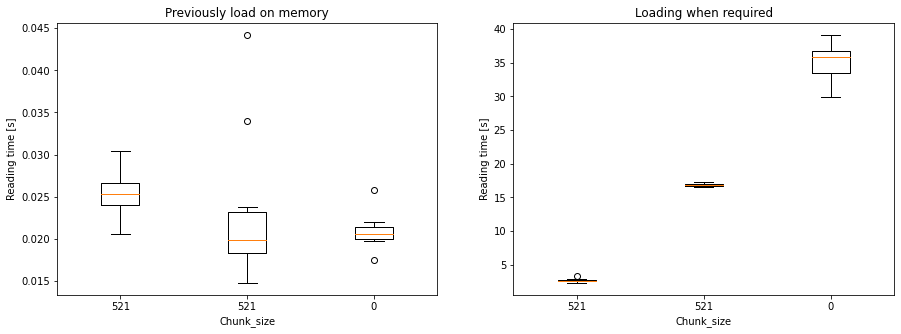

In [37]:
times_plot = [times1, times2, times6, times7, times8, times9]

t_loaded = [t for t in times_plot if t.loaded_in_memory]
t_not_loaded = [t for t in times_plot if not t.loaded_in_memory]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Previously load on memory')
ax[1].set_title('Loading when required')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.chunk_size for t in t_list])
    ax[i].set_xlabel('Chunk_size')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

Comments:
* Loading the data previously is the most significant difference regarding the total training time.

* Chunking the data has a large effect when it is not previously loaded. Also, the chunk size affects the reading time.

* Using previously standardized data instead of performing the standardization for each batch helps reducing the time. 